<a href="https://colab.research.google.com/github/EmanueleGiavardi/BSP_project/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
#dataset_folder (Drive) = "/content/drive/MyDrive/BSP_Project/set-a-text/"
test_sp = "/content/drive/MyDrive/BSP_Project/set-a-text/a01.csv"

def extract_stochastic_process(filename):
    df = pd.read_csv(filename, skiprows=2, header=None)

    timestamps = df[0]
    stochastic_process = []
    for i in range (1,5):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        stochastic_process.append(AECG_cleaned.astype(float))

    return timestamps, stochastic_process

# t -> timestamp [60 seconds]
# q = 4 channels:
#   S1[0] = -> AECG1
#   S1[1] = -> AECG2
#   S1[2] = -> AECG3
#   S1[3] = -> AECG4

t, S1 = extract_stochastic_process(test_sp)
fs = 1000 #sampling frequency

# for semplicity purposes, here we just consider one realization, AECG1, for blocks 1 and 2
AECG1 = S1[0]
AECG1

array([-3.3, -3.8, -4.4, ...,  4.2,  4.2,  4.1])

In [14]:
from scipy.fftpack import fft

colors = ['blue', 'green', 'orange', 'red']

def plot_AECG(AECG):
    plt.figure(figsize=(14, 6))
    plt.plot(t, AECG)
    plt.title('AECG1')
    plt.xlabel('Time [s]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

def plot_fft_magnitude(signal, fs, x_limit=100, y_limit=100000):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    magnitude = np.abs(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, x_limit)
    plt.ylim(0, y_limit)
    plt.grid()
    plt.show()

def plot_fft_phase(signal, fs):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    phase = np.angle(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, phase)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase')
    plt.grid()
    plt.show()

def plot_stochastic_process(process):
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    for i in range(0, 4):
        axes[i].plot(t, process[i], color=colors[i])
        axes[i].set_title(f"AECG{i+1}")

    plt.xlabel("Time (samples)")

    plt.tight_layout()
    plt.show()

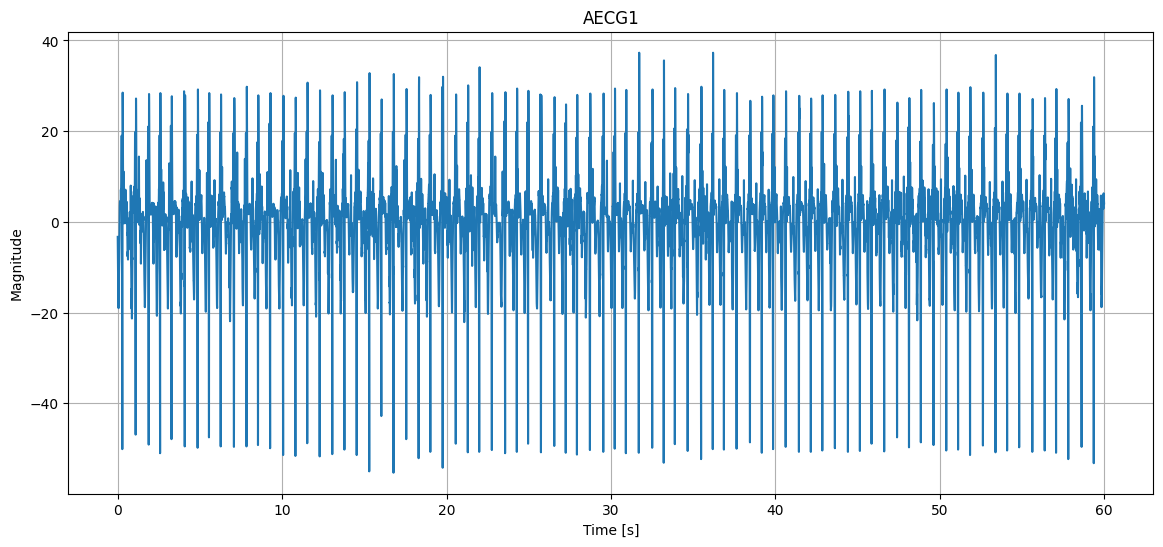

In [15]:
plot_AECG(AECG1)
#plot_stochastic_process(S1)
#plot_AECG_spectrum(AECG, fs)

## <b>Baseline Wander Remover</b>

#### Linear Phase High-Pass Filter creation (library)

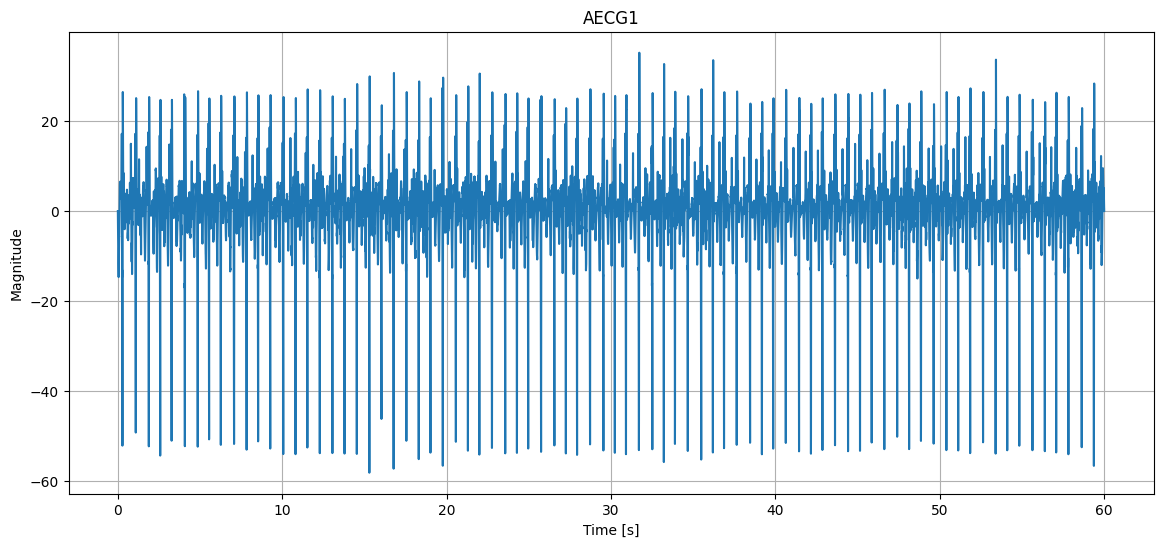

In [16]:
from scipy.signal import firwin, filtfilt

def highpass_fir_filter(signal, fs, cutoff, num_taps=1000):

    nyquist = 0.5 * fs
    cutoff_normalized = cutoff / nyquist

    # crea i coefficienti del filtro (valori del sinc finestrato di lunghezza num_taps)
    fir_coefficients = firwin(num_taps, cutoff_normalized, pass_zero=False)

    # applica la convoluzione tra i valori del sinc finestrato e il segnale
    filtered_signal = filtfilt(fir_coefficients, [1.0], signal)

    return filtered_signal, fir_coefficients

# Parametri
fs = 1000  # Frequenza di campionamento (Hz)
cutoff = 3  # Frequenza di taglio (Hz)
num_taps = 1001  # Numero di taps


# Applicazione del filtro
filtered_AECG, fir_coefficients = highpass_fir_filter(AECG1, fs, cutoff, num_taps)

plot_AECG(filtered_AECG)

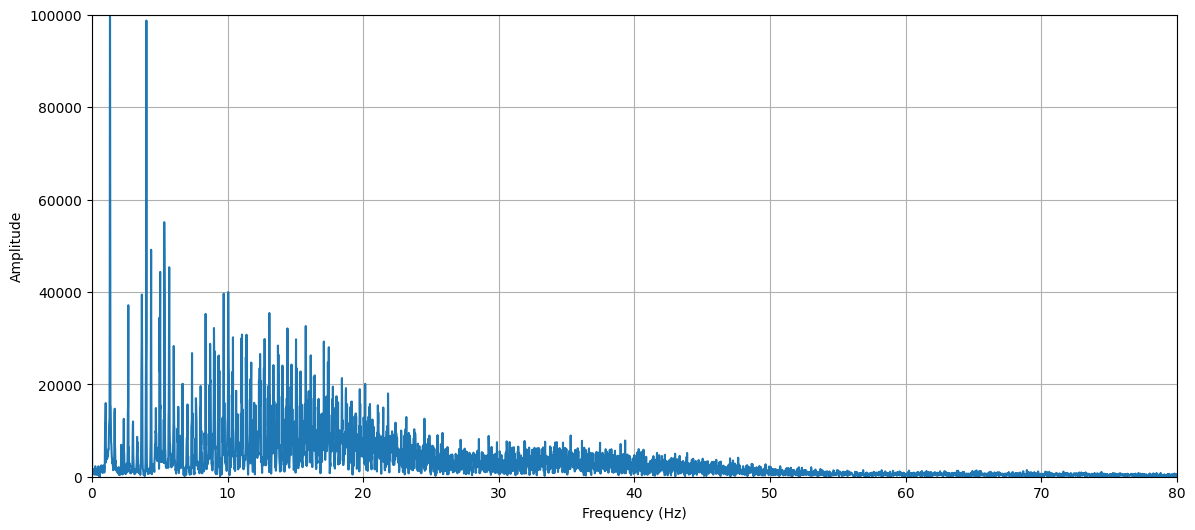

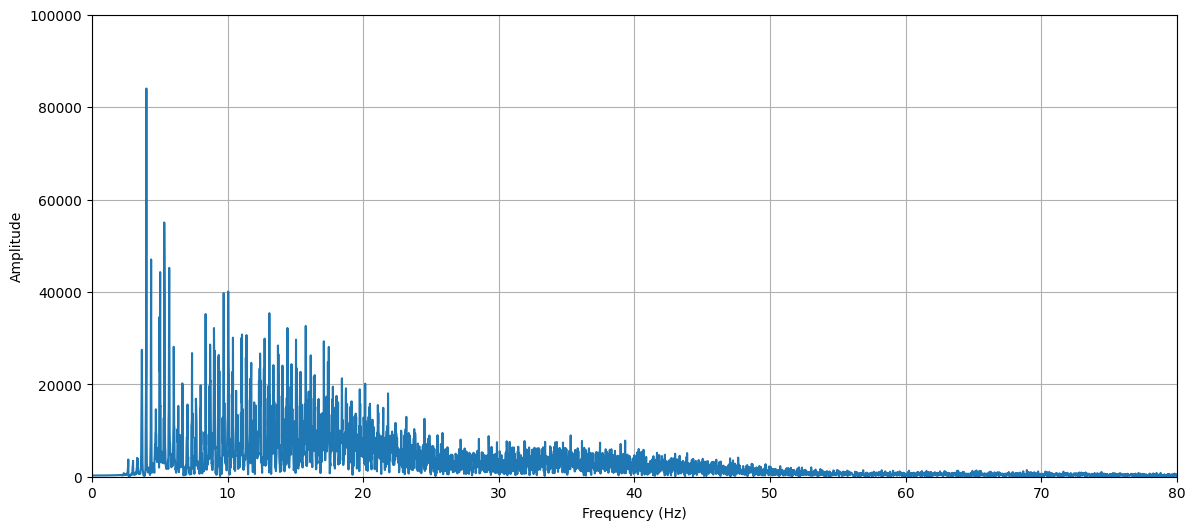

In [17]:
# Spettro del segnale originale
plot_fft_magnitude(AECG1, fs, x_limit=80)

# Spettro del segnale filtrato
plot_fft_magnitude(filtered_AECG, fs, x_limit=80)

## <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)